# Eine empirische Analyse von Prior-Daten Konflikten in Bayesianischen neuronalen Netzen

## Step1: Analyse N(0, 1)

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal, norm, uniform, norm, beta, bernoulli
import statsmodels.api as sm
from sklearn import linear_model

%matplotlib inline

2023-05-03 14:09:42.356455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Applications/anaconda3/envs/abgabe/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tf.random.set_seed(123)
np.random.seed(123)

In [3]:
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : "18",
          'font.family' : 'lmodern',
          'legend.fontsize': "18", 
          }
plt.rcParams.update(params) 

/var/folders/zp/1hx5lv0d4b95fw3_z7q4t74h0000gn/T/ipykernel_32017/514745690.py:1: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


In [4]:
def normal_pdf(x, mu, sigma):
    return 1/np.sqrt(2*np.pi*np.power(sigma, 2)) * np.exp(-1/2 * np.power((x-mu)/sigma, 2))

def log_normal_pdf(x, mu, sigma):
    return -1/2 * np.log(2*np.pi*np.power(sigma, 2)) - 1/2 * np.power((x-mu)/sigma,2)

def like(x, y, beta, sigma):
    return [np.prod(normal_pdf(y, x@np.array(b), sigma)) for b in beta]

def log_like(x, y, beta, sigma):
    return [np.sum(log_normal_pdf(y, x@np.array(b), sigma)) for b in beta]

neg_log_like = lambda y, rv_y: -rv_y.log_prob(y)

In [5]:
def create_train_data(*args, kernel = 0, noise = 1, n = 100):
    """
    args: beta values, i.e. 1,2,3,4,...
    mu: y = f(x) + eps where eps ~ N(mu, noise)
    noise: y = f(x) + eps where eps ~ N(mu, noise)
    n: number of samples
    
    f(x) = x^t*b
    """
    num_features = args[0].shape[0] #len(list(args)) - 1
    X = np.ones(n).reshape(-1,1)
    for i in range(num_features - 1):
        x_i = np.linspace(0, 1, n).reshape(-1,1)
        X = np.hstack((X, x_i))
    #beta = np.array([[a] for a in list(args)]) # b0, b1,...
    beta = args[0]
    eps = np.random.normal(kernel, noise, size=(n,1))
    Y = X @ beta + eps
    return X, Y

In [6]:
def normal_conj_posterior_uni(y, n, theta, tau, sigma):
    mean = theta * np.power(sigma, 2)/(n * np.power(tau, 2) + np.power(sigma, 2)) + y.mean() * n * np.power(tau, 2)/(n * np.power(tau, 2) + np.power(sigma, 2))
    var = np.power(tau, 2) * np.power(sigma,2)/(n * np.power(tau, 2) + np.power(sigma, 2))
    return mean, var

def normal_conj_posterior_mult(x, y, sigma, tau, p):
    A = np.power(sigma, 2) * x.transpose()@x + 1/np.power(tau, 2) * np.identity(p)
    mean = np.power(sigma, 2) * np.linalg.inv(A)@x.transpose()@y
    var = np.linalg.inv(A)
    return mean, var

def normal_conj_post_mult_gen(x, y, sigma, theta_0, tau_0):
    p = theta_0.shape[0]
    A = 1/np.power(sigma, 2) + x.transpose()@x + 1/np.power(tau_0, 2)*np.identity(p)
    mean = 1/np.power(sigma, 2) * np.linalg.inv(A)@x.transpose()@y + 1/np.power(tau_0, 2) * np.linalg.inv(A).transpose()@theta_0
    var = np.linalg.inv(A)
    return mean, var

In [7]:
def perform_analysis(X, Y, theta, tau, theta_0, tau_0):
    """
    X, Y: data
    theta: b0, b1, ...
    tau: aleatoric noise, i.e. sigma^2
    theta_0: prior assumption for mean of normal dist
    tau_0: prior assumption for sigma of normal dist
    p(theta) ~ N(theta_0, tau_0)
    """
    def _prior(kernel_size, bias_size, dtype = None):
        n = kernel_size + bias_size # num of params
        return tf.keras.Sequential([
           tfp.layers.DistributionLambda(
               #lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc = 0, scale=1))
               #lambda t: tfp.distributions.Normal(loc = tf.ones(n) * theta_0.ravel()[::-1], scale= tf.ones(n) * tau_0) # kernel always first
               lambda t: tfp.distributions.MultivariateNormalDiag(loc = tf.ones(n) * theta_0.ravel()[::-1], scale_diag= tf.ones(n) * np.sqrt(tau_0))
           )                     
      ])

    #mean-field posterior
    def _posterior(kernel_size, bias_size, dtype = None):
        n = kernel_size + bias_size # num of params
        #c = np.log(np.expm1(1))
        return tf.keras.Sequential([
            tfp.layers.VariableLayer(2*n, dtype=dtype),
            tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
                tfp.distributions.Normal(loc = t[..., :n], scale = 1e-5 + tf.math.softplus( t[...,n:]) )
            ))
        ])
    
    # Calculate MLE estimates:
    theta_mle = np.linalg.inv(X.transpose()@X)@X.transpose()@Y
    var_theta_mle = tau * np.linalg.inv(X.transpose()@X)
    # calculate exact posterior (normal-normal model)
    ex_mean, ex_var = normal_conj_post_mult_gen(X, Y, tau, theta_0, tau_0)
    # fit BNN
    cb = tf.keras.callbacks.EarlyStopping(patience = 300, verbose = 1, min_delta = 1e-4)
    bs = 32 if X.shape[0] > 32 else X.shape[0]
    kl_weight = 1/int(X.shape[0]/32) if X.shape[0] > 32 else 1
    mod = tf.keras.models.Sequential([
        tfp.layers.DenseVariational(units=1, make_posterior_fn=_posterior, make_prior_fn=_prior, kl_weight = kl_weight, activation=None),
        tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=tf.convert_to_tensor(np.sqrt(tau), dtype=tf.float32)))
    ])

    mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss = neg_log_like)
    history = mod.fit(X[:,1].reshape(-1,1), Y.reshape(-1,1), epochs = 50000, verbose = False, batch_size = bs, validation_split=.3, callbacks=[cb])
    
    epochs = mod.optimizer.iterations.numpy()
    loss = history.history["loss"][-1]
    
    mu = mod.layers[0]._posterior(np.array([0])).mean().numpy()[0]
    bias = mod.layers[0]._posterior(np.array([0])).mean().numpy()[1]
    mu_s = mod.layers[0]._posterior(np.array([0])).stddev().numpy()[0]
    bias_s = mod.layers[0]._posterior(np.array([0])).stddev().numpy()[1]
    
    plt.plot(history.history["loss"], label="Verlust")
    plt.plot(history.history["val_loss"], label="Validierungs Verlust")
    plt.xlabel("Epoche")
    plt.ylabel("Negative Log-Likelihood")
    plt.legend()
    plt.show()
    
    return "n: {}, optimizer_iters: {}, loss: {} \ntheta_MLE: {} \nVar(theta_MLE): {} \ntheta_exact: {} \nVar(theta_exact): {} \ntheta_BNN: {} \nVar(theta_BNN): {}".format(X.shape[0], epochs, loss, theta_mle, var_theta_mle, ex_mean, ex_var, (bias, mu), (np.power(bias_s, 2), np.power(mu_s,2)))
    

Parameter des Modells

In [8]:
beta = np.array([[10], [20]])
aleatoric_noise = np.array([1.])

### Durchführung der Analyse

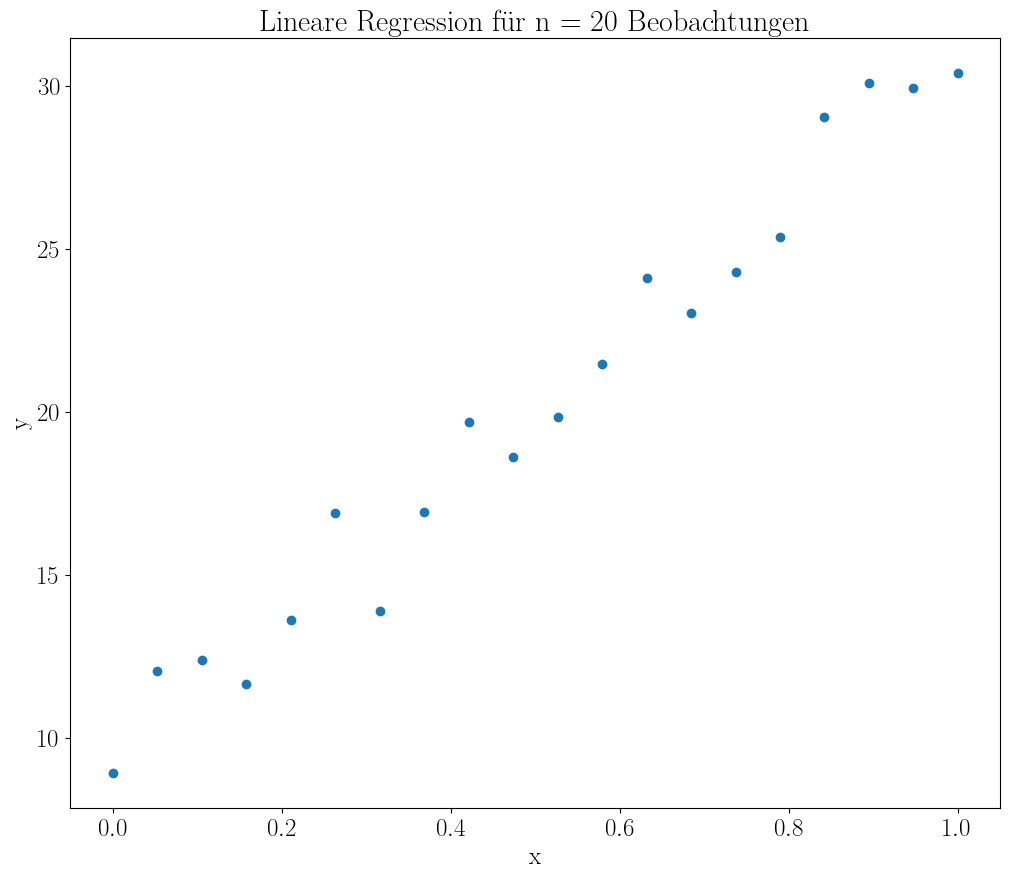

In [9]:
n = 20

X10, Y10 = create_train_data(beta, noise=aleatoric_noise, n = n)
plt.figure(figsize=(12,10))
plt.scatter(X10[:,1], Y10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Lineare Regression für n = 20 Beobachtungen")
plt.savefig("bilder/LM_10.png", dpi=1000, bbox_inches='tight')
plt.show()

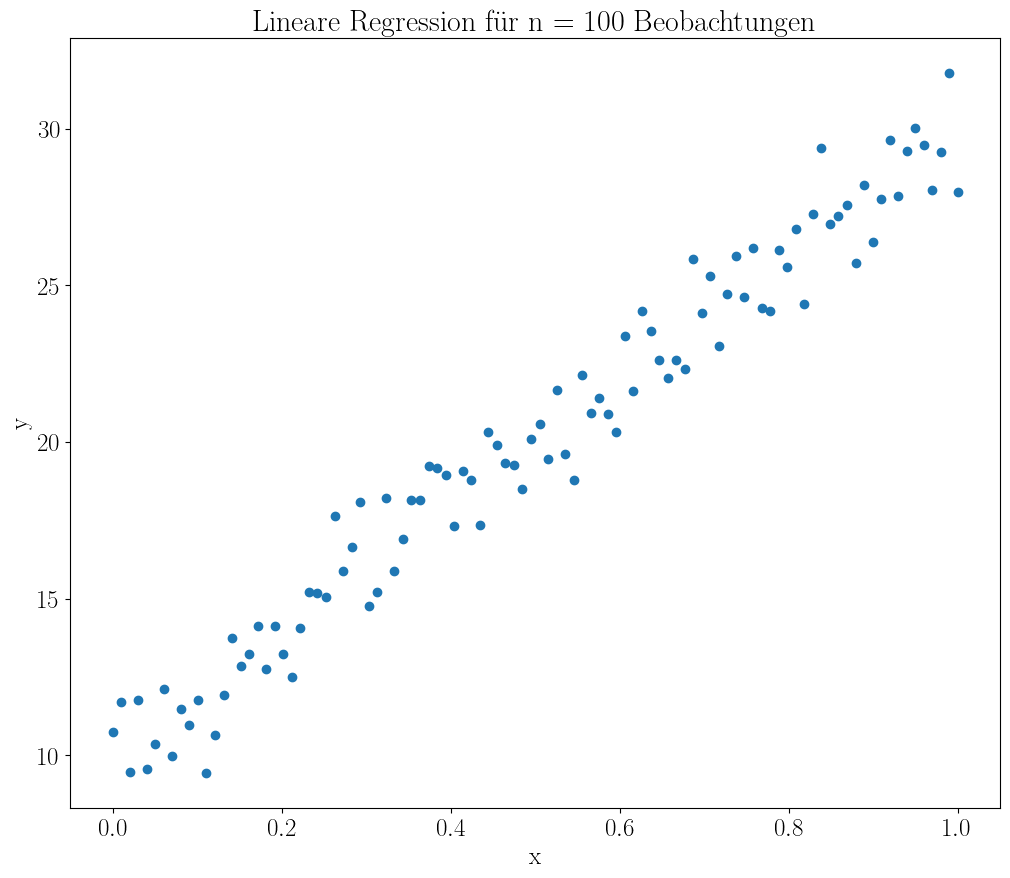

In [10]:
n = 100

X100, Y100 = create_train_data(beta, noise=aleatoric_noise, n = n) 
plt.figure(figsize=(12,10))
plt.scatter(X100[:,1], Y100)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Lineare Regression für n = 100 Beobachtungen")
plt.savefig("bilder/LM_100.png", dpi=1000, bbox_inches='tight')
plt.show()

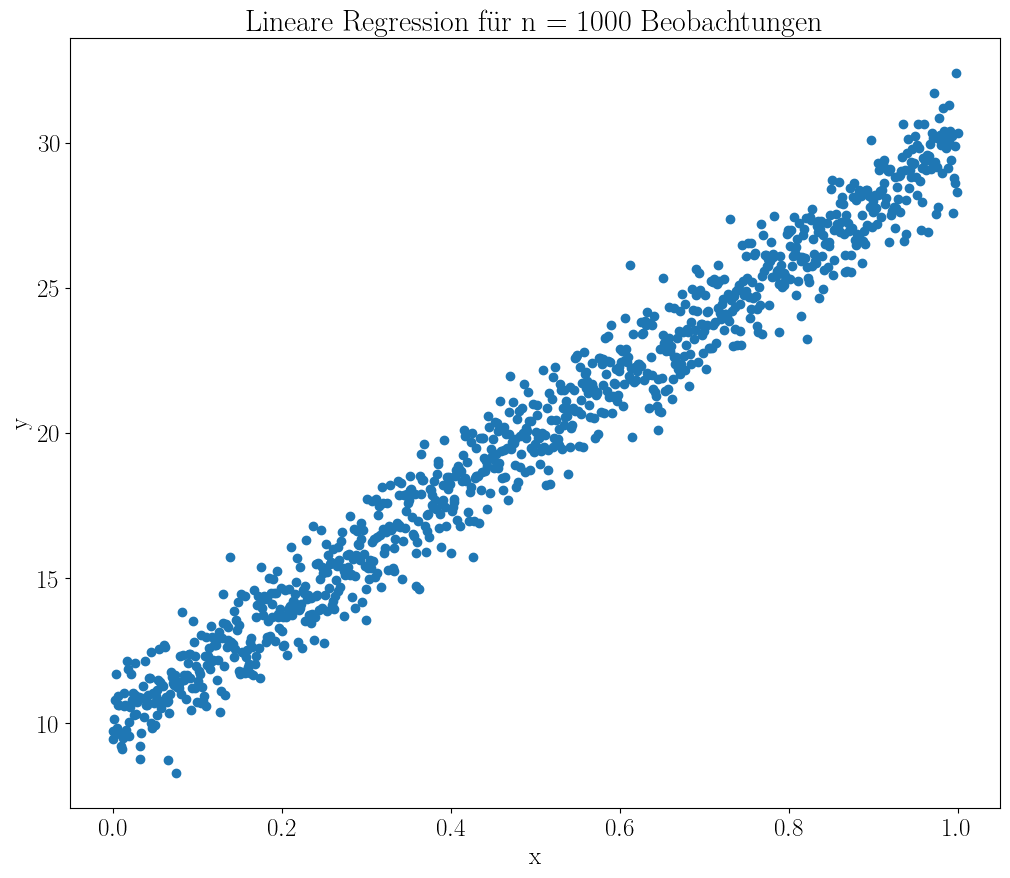

In [11]:
n = 1000

X1000, Y1000 = create_train_data(beta, noise=aleatoric_noise, n = n) 
plt.figure(figsize=(12,10))
plt.scatter(X1000[:,1], Y1000)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Lineare Regression für n = 1000 Beobachtungen")
plt.savefig("bilder/LM_1000.png", dpi=1000, bbox_inches='tight')
plt.show()

n = 20

2023-05-03 14:10:57.962416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Epoch 1077: early stopping


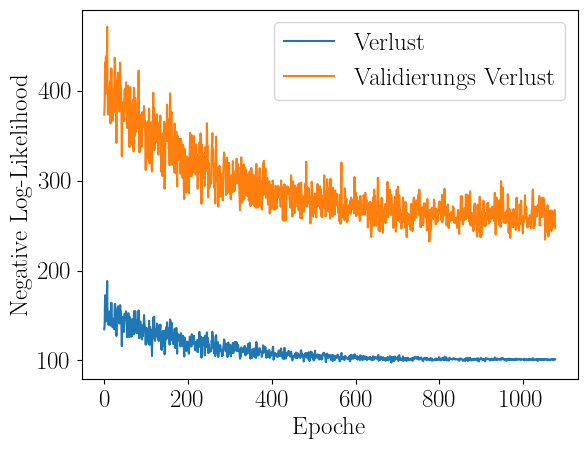

n: 20, optimizer_iters: 1077, loss: 101.3093490600586 
theta_MLE: [[ 9.35838598]
 [21.51206351]] 
Var(theta_MLE): [[ 0.18571429 -0.27142857]
 [-0.27142857  0.54285714]] 
theta_exact: [[12.35731286]
 [11.85704288]] 
Var(theta_exact): [[ 0.1202577 -0.1496063]
 [-0.1496063  0.2992126]] 
theta_BNN: (5.0930347, 2.3428028) 
Var(theta_BNN): (0.3216012476519978, 0.41401335661852556)
Epoch 3012: early stopping


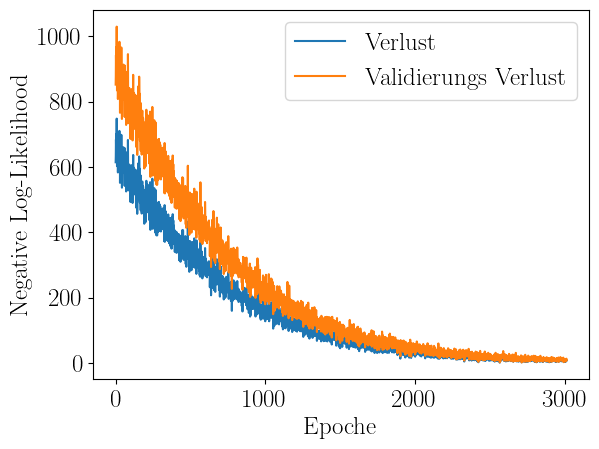

n: 20, optimizer_iters: 3012, loss: 6.979032039642334 
theta_MLE: [[ 9.35838598]
 [21.51206351]] 
Var(theta_MLE): [[ 0.18571429 -0.27142857]
 [-0.27142857  0.54285714]] 
theta_exact: [[10.56776383]
 [16.34523186]] 
Var(theta_exact): [[ 0.1202577 -0.1496063]
 [-0.1496063  0.2992126]] 
theta_BNN: (10.202957, 18.457584) 
Var(theta_BNN): (0.3368762566830732, 0.4736276859400199)


In [12]:
erg1 = perform_analysis(X10, Y10, beta, aleatoric_noise, np.array([[0],[0]]), np.array([1]))
print(erg1)
erg2 = perform_analysis(X10, Y10,beta, aleatoric_noise, np.array([[10],[20]]), np.array([1]))
print(erg2)

n = 100

Epoch 1077: early stopping


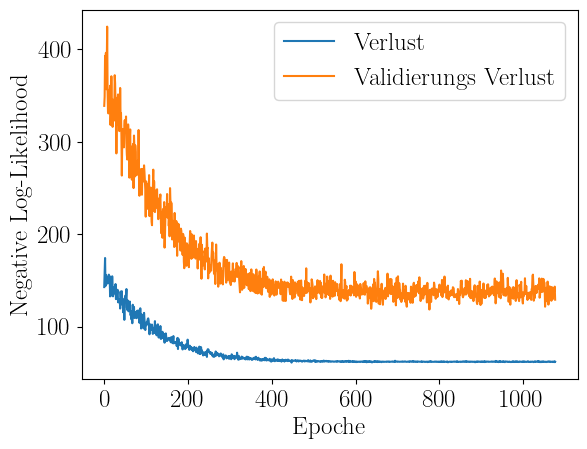

n: 100, optimizer_iters: 3231, loss: 62.07318115234375 
theta_MLE: [[ 9.99104858]
 [20.01087801]] 
Var(theta_MLE): [[ 0.03940594 -0.05881188]
 [-0.05881188  0.11762376]] 
theta_exact: [[11.09952382]
 [17.00975155]] 
Var(theta_exact): [[ 0.03479971 -0.04999158]
 [-0.04999158  0.09998317]] 
theta_BNN: (9.279131, 4.2111373) 
Var(theta_BNN): (0.217553060568779, 0.47716290499137415)
Epoch 1442: early stopping


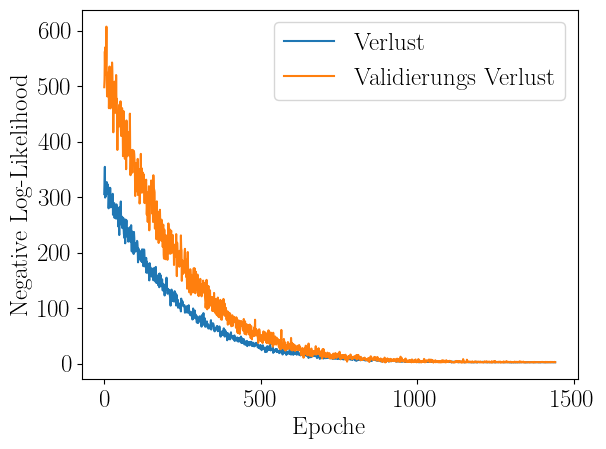

n: 100, optimizer_iters: 4326, loss: 2.5058164596557617 
theta_MLE: [[ 9.99104858]
 [20.01087801]] 
Var(theta_MLE): [[ 0.03940594 -0.05881188]
 [-0.05881188  0.11762376]] 
theta_exact: [[10.44768928]
 [18.50949906]] 
Var(theta_exact): [[ 0.03479971 -0.04999158]
 [-0.04999158  0.09998317]] 
theta_BNN: (10.094783, 19.826683) 
Var(theta_BNN): (0.18735285599089568, 0.35482550018432235)


In [13]:
theta_0 = np.array([[0],[0]])
tau_0 = np.array([1.])

erg3 = perform_analysis(X100, Y100, beta, aleatoric_noise, theta_0, tau_0)
print(erg3)

theta_0 = np.array([[10],[20]])
erg4 = perform_analysis(X100, Y100, beta, aleatoric_noise, theta_0, tau_0)
print(erg4)

n = 1000

Epoch 455: early stopping


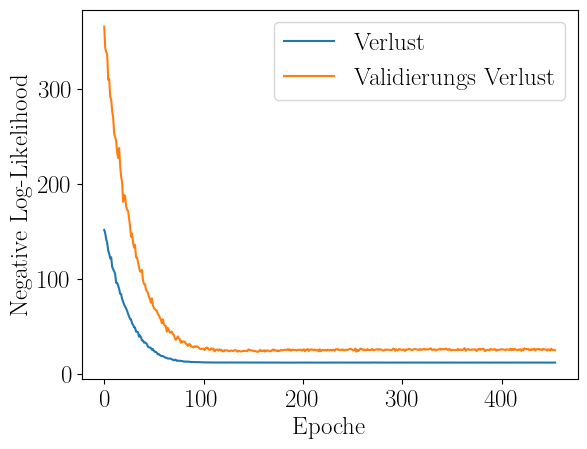

n: 1000, optimizer_iters: 10010, loss: 12.300609588623047 
theta_MLE: [[ 9.97312986]
 [19.97234204]] 
Var(theta_MLE): [[ 0.00399401 -0.00598801]
 [-0.00598801  0.01197602]] 
theta_exact: [[10.10951714]
 [19.61988964]] 
Var(theta_exact): [[ 0.00393917 -0.00588234]
 [-0.00588234  0.01176468]] 
theta_BNN: (12.529782, 10.467463) 
Var(theta_BNN): (0.026449066755592554, 0.1414906700094356)
Epoch 925: early stopping


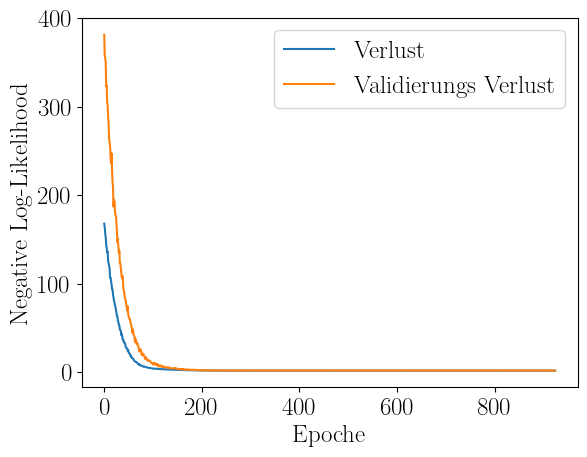

n: 1000, optimizer_iters: 20350, loss: 1.5419820547103882 
theta_MLE: [[ 9.97312986]
 [19.97234204]] 
Var(theta_MLE): [[ 0.00399401 -0.00598801]
 [-0.00598801  0.01197602]] 
theta_exact: [[10.03126206]
 [19.79635988]] 
Var(theta_exact): [[ 0.00393917 -0.00588234]
 [-0.00588234  0.01176468]] 
theta_BNN: (9.9990635, 20.022818) 
Var(theta_BNN): (0.034640112103549114, 0.18159761982741518)


In [14]:
theta_0 = np.array([[0],[0]])
tau_0 = np.array([1.])

erg5 = perform_analysis(X1000, Y1000, beta, aleatoric_noise, theta_0, tau_0)
print(erg5)

theta_0 = np.array([[10],[20]])
erg6 = perform_analysis(X1000, Y1000,beta, aleatoric_noise, theta_0, tau_0)
print(erg6)

## Test für n = 10000 Stichproben

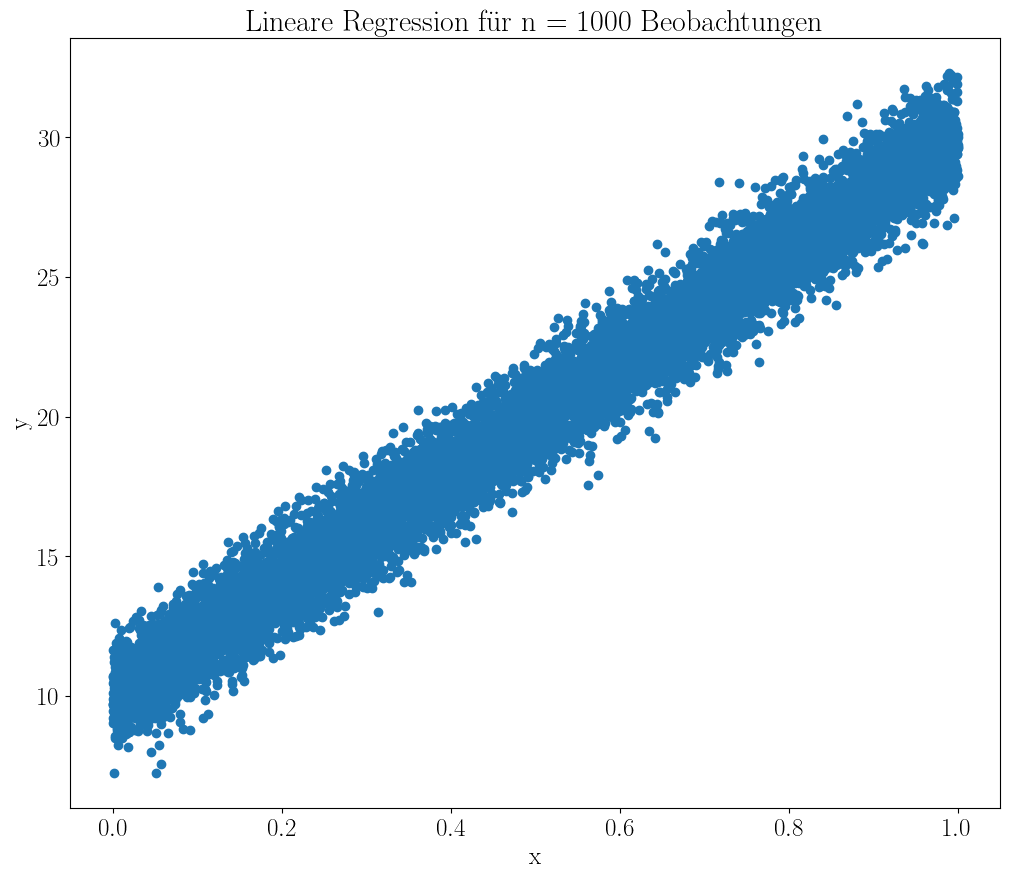

In [15]:
n = 10000

X10000, Y10000 = create_train_data(beta, noise=aleatoric_noise, n = n) 
plt.figure(figsize=(12,10))
plt.scatter(X10000[:,1], Y10000)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Lineare Regression für n = 1000 Beobachtungen")
plt.show()

Epoch 376: early stopping


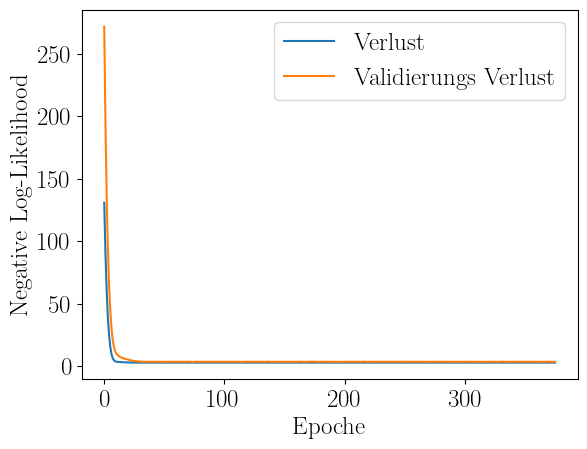

n: 10000, optimizer_iters: 82344, loss: 2.9090747833251953 
theta_MLE: [[10.02471337]
 [19.99066737]] 
Var(theta_MLE): [[ 0.00039994 -0.00059988]
 [-0.00059988  0.00119976]] 
theta_exact: [[10.03866585]
 [19.95475599]] 
Var(theta_exact): [[ 0.00039938 -0.0005988 ]
 [-0.0005988   0.0011976 ]] 
theta_BNN: (10.753256, 17.746939) 
Var(theta_BNN): (0.0029797225777584146, 0.012756830040754119)


In [16]:

theta_0 = np.array([[0],[0]])
tau_0 = np.array([1])

erg5 = perform_analysis(X10000, Y10000, beta, aleatoric_noise, theta_0, tau_0)
print(erg5)

# Effekt der aleatorischen Unsicherheit in der Prior-Verteilung: N(0, .1)

Epoch 400: early stopping


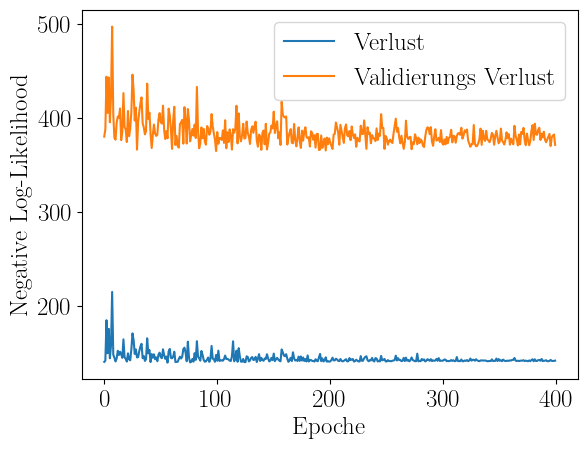

n: 20, optimizer_iters: 400, loss: 142.46221923828125 
theta_MLE: [[ 9.35838598]
 [21.51206351]] 
Var(theta_MLE): [[ 0.18571429 -0.27142857]
 [-0.27142857  0.54285714]] 
theta_exact: [[3.15094883]
 [1.91123147]] 
Var(theta_exact): [[ 0.00834181 -0.00085087]
 [-0.00085087  0.00935961]] 
theta_BNN: (0.8282721, 0.30538163) 
Var(theta_BNN): (0.09231933203192799, 0.0702806658387658)
Epoch 3649: early stopping


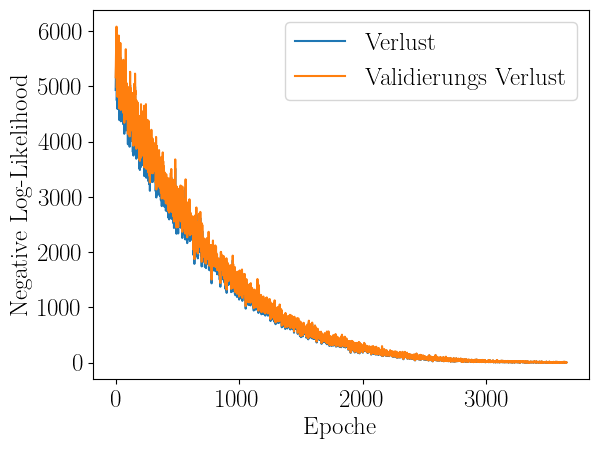

n: 20, optimizer_iters: 3649, loss: 1.6672859191894531 
theta_MLE: [[ 9.35838598]
 [21.51206351]] 
Var(theta_MLE): [[ 0.18571429 -0.27142857]
 [-0.27142857  0.54285714]] 
theta_exact: [[ 9.79101723]
 [19.77957003]] 
Var(theta_exact): [[ 0.00834181 -0.00085087]
 [-0.00085087  0.00935961]] 
theta_BNN: (9.982085, 19.601496) 
Var(theta_BNN): (0.052892229162943005, 0.0870763608635663)


In [17]:

theta_0 = np.array([[0],[0]])
tau_0 = np.array([.1])

erg1 = perform_analysis(X10, Y10, beta, aleatoric_noise, theta_0, tau_0)
print(erg1)

theta_0 = np.array([[10],[20]])
erg2 = perform_analysis(X10, Y10,beta, aleatoric_noise, theta_0, tau_0)
print(erg2)

Epoch 492: early stopping


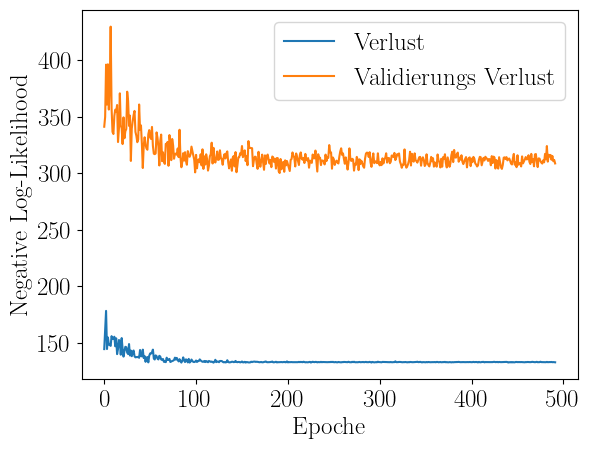

n: 100, optimizer_iters: 1476, loss: 132.85931396484375 
theta_MLE: [[ 9.99104858]
 [20.01087801]] 
Var(theta_MLE): [[ 0.03940594 -0.05881188]
 [-0.05881188  0.11762376]] 
theta_exact: [[8.56552475]
 [5.45055459]] 
Var(theta_exact): [[ 0.00550473 -0.00208727]
 [-0.00208727  0.0082263 ]] 
theta_BNN: (2.1570618, 0.89866483) 
Var(theta_BNN): (0.04844412829131195, 0.04749051206263766)
Epoch 1353: early stopping


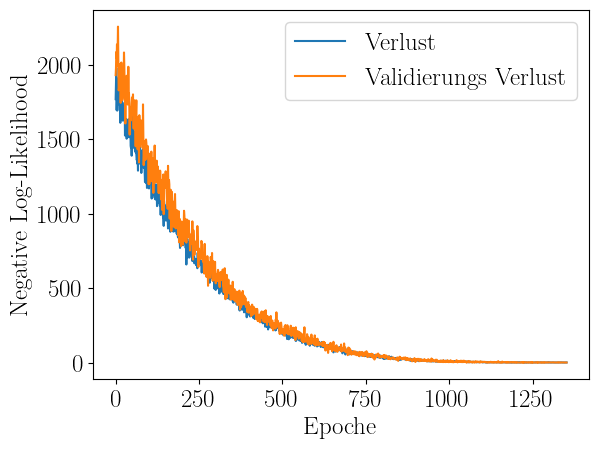

n: 100, optimizer_iters: 4059, loss: 1.8760886192321777 
theta_MLE: [[ 9.99104858]
 [20.01087801]] 
Var(theta_MLE): [[ 0.03940594 -0.05881188]
 [-0.05881188  0.11762376]] 
theta_exact: [[ 9.89571622]
 [19.81587839]] 
Var(theta_exact): [[ 0.00550473 -0.00208727]
 [-0.00208727  0.0082263 ]] 
theta_BNN: (10.010416, 19.843493) 
Var(theta_BNN): (0.04444006059826067, 0.07574993998082391)


In [18]:

theta_0 = np.array([[0],[0]])
tau_0 = np.array([.1])

erg3 = perform_analysis(X100, Y100, beta, aleatoric_noise, theta_0, tau_0)
print(erg3)

theta_0 = np.array([[10],[20]])
erg4 = perform_analysis(X100, Y100,beta, aleatoric_noise, theta_0, tau_0)
print(erg4)

Epoch 555: early stopping


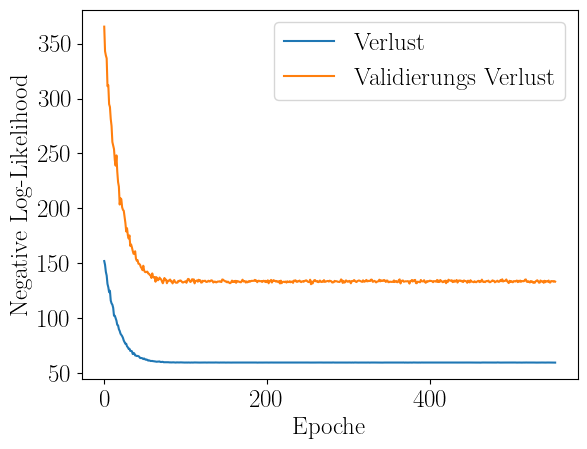

n: 1000, optimizer_iters: 12210, loss: 59.295536041259766 
theta_MLE: [[ 9.97312986]
 [19.97234204]] 
Var(theta_MLE): [[ 0.00399401 -0.00598801]
 [-0.00598801  0.01197602]] 
theta_exact: [[12.476709  ]
 [12.42004846]] 
Var(theta_exact): [[ 0.00191087 -0.00220332]
 [-0.00220332  0.00484204]] 
theta_BNN: (9.427163, 4.3255353) 
Var(theta_BNN): (0.021903700635025558, 0.04063152989413532)
Epoch 514: early stopping


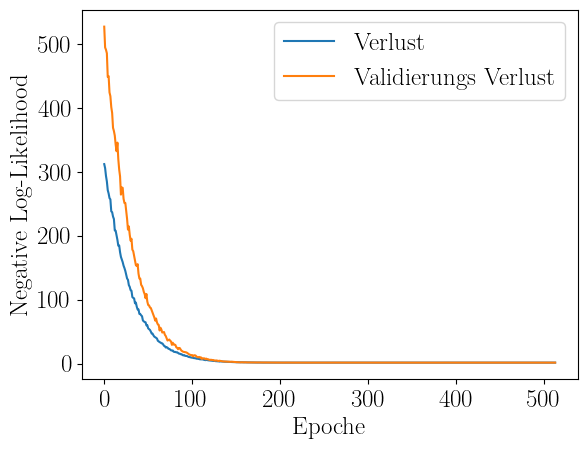

n: 1000, optimizer_iters: 11308, loss: 1.4267666339874268 
theta_MLE: [[ 9.97312986]
 [19.97234204]] 
Var(theta_MLE): [[ 0.00399401 -0.00598801]
 [-0.00598801  0.01197602]] 
theta_exact: [[ 9.98092819]
 [19.90079629]] 
Var(theta_exact): [[ 0.00191087 -0.00220332]
 [-0.00220332  0.00484204]] 
theta_BNN: (9.971739, 19.982014) 
Var(theta_BNN): (0.0193023503246883, 0.03557603203748627)


In [19]:

theta_0 = np.array([[0],[0]])
tau_0 = np.array([.1])

erg5 = perform_analysis(X1000, Y1000, beta, aleatoric_noise, theta_0, tau_0)
print(erg5)

theta_0 = np.array([[10],[20]])
erg6 = perform_analysis(X1000, Y1000,beta, aleatoric_noise, theta_0, tau_0)
print(erg6)

## Test n=200000 Stichproben

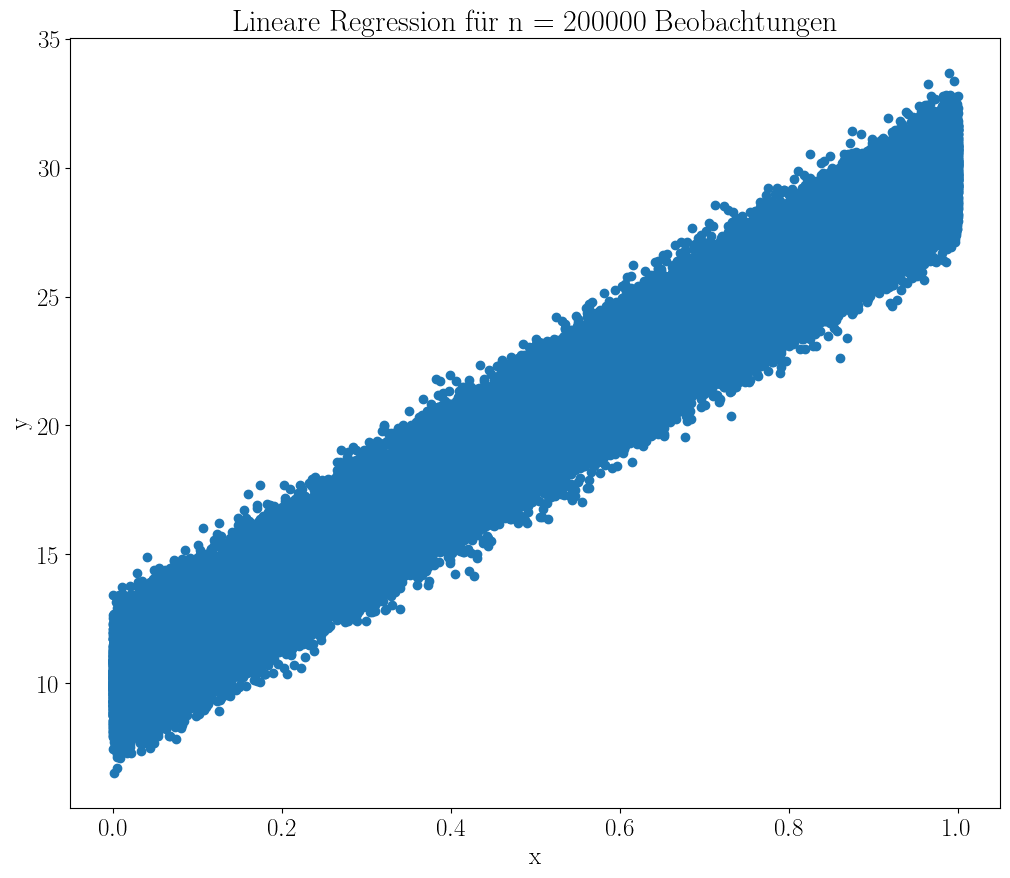

In [20]:
n = 200000

X200000, Y200000 = create_train_data(beta, noise=aleatoric_noise, n = n) 
plt.figure(figsize=(12,10))
plt.scatter(X200000[:,1], Y200000)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Lineare Regression für n = 200000 Beobachtungen")
plt.show()

Epoch 476: early stopping


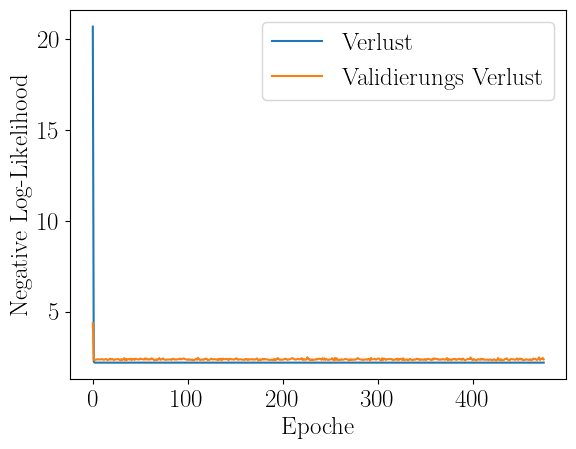

n: 200000, optimizer_iters: 2082500, loss: 2.1867716312408447 
theta_MLE: [[ 9.99880901]
 [20.00684655]] 
Var(theta_MLE): [[ 1.999985e-05 -2.999970e-05]
 [-2.999970e-05  5.999940e-05]] 
theta_exact: [[10.03878025]
 [19.91656574]] 
Var(theta_exact): [[ 1.98707272e-05 -2.97612261e-05]
 [-2.97612261e-05  5.95519156e-05]] 
theta_BNN: (10.407036, 18.781301) 
Var(theta_BNN): (0.0002574227916523619, 0.0015635745363601489)


In [21]:

theta_0 = np.array([[0],[0]])
tau_0 = np.array([.1])

erg5 = perform_analysis(X200000, Y200000, beta, aleatoric_noise, theta_0, tau_0)
print(erg5)

# Effekt der aleatorischen Unsicherheit in der Prior-Verteilung: N(0, 10)

Epoch 2274: early stopping


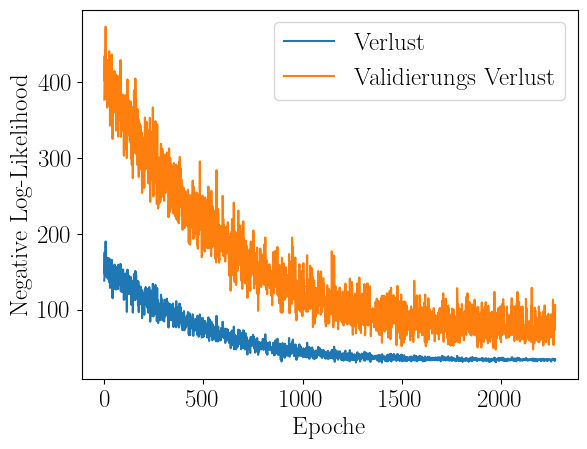

n: 20, optimizer_iters: 2274, loss: 34.488792419433594 
theta_MLE: [[ 9.35838598]
 [21.51206351]] 
Var(theta_MLE): [[ 0.18571429 -0.27142857]
 [-0.27142857  0.54285714]] 
theta_exact: [[11.60542451]
 [14.4053078 ]] 
Var(theta_exact): [[ 0.1785676  -0.25015503]
 [-0.25015503  0.47779611]] 
theta_BNN: (11.0919075, 8.226226) 
Var(theta_BNN): (0.8905814191499282, 2.7127458977957417)
Epoch 2202: early stopping


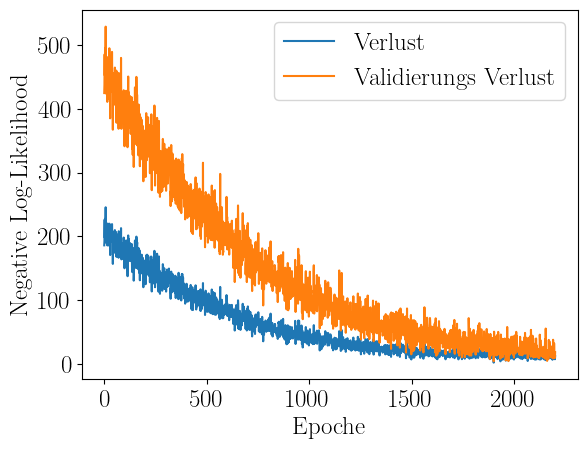

n: 20, optimizer_iters: 2202, loss: 12.590153694152832 
theta_MLE: [[ 9.35838598]
 [21.51206351]] 
Var(theta_MLE): [[ 0.18571429 -0.27142857]
 [-0.27142857  0.54285714]] 
theta_exact: [[11.57325026]
 [14.47585151]] 
Var(theta_exact): [[ 0.1785676  -0.25015503]
 [-0.25015503  0.47779611]] 
theta_BNN: (11.211188, 14.540767) 
Var(theta_BNN): (0.896689954313107, 2.206000837746217)


In [22]:

theta_0 = np.array([[0],[0]])
tau_0 = np.array([10])

erg1 = perform_analysis(X10, Y10, beta, aleatoric_noise, theta_0, tau_0)
print(erg1)

theta_0 = np.array([[10],[20]])
erg2 = perform_analysis(X10, Y10,beta, aleatoric_noise, theta_0, tau_0)
print(erg2)

Epoch 1077: early stopping


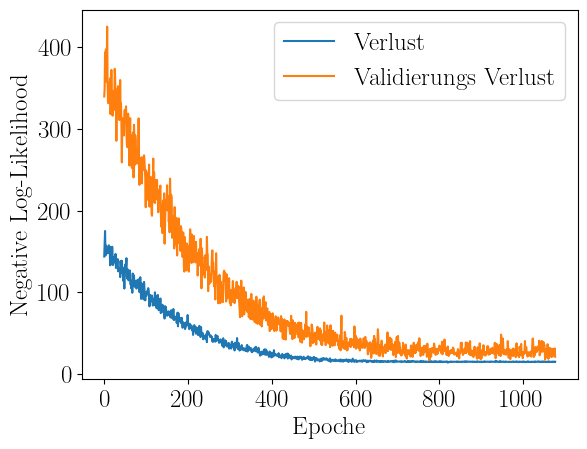

n: 100, optimizer_iters: 3231, loss: 15.162793159484863 
theta_MLE: [[ 9.99104858]
 [20.01087801]] 
Var(theta_MLE): [[ 0.03940594 -0.05881188]
 [-0.05881188  0.11762376]] 
theta_exact: [[10.55762992]
 [18.29848158]] 
Var(theta_exact): [[ 0.03899514 -0.05762548]
 [-0.05762548  0.11413235]] 
theta_BNN: (12.240491, 11.017672) 
Var(theta_BNN): (0.33582324318217616, 1.595713806319182)
Epoch 1077: early stopping


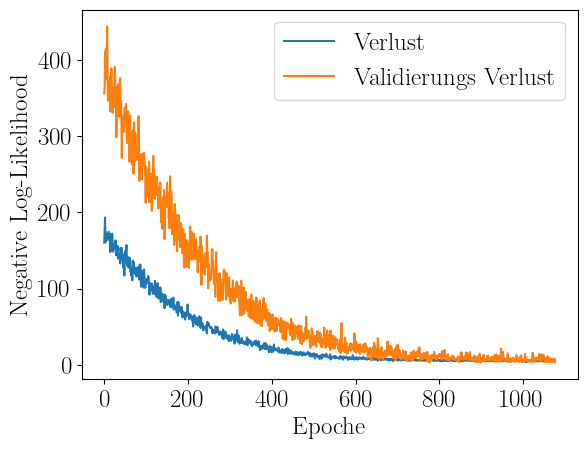

n: 100, optimizer_iters: 3231, loss: 4.656566143035889 
theta_MLE: [[ 9.99104858]
 [20.01087801]] 
Var(theta_MLE): [[ 0.03940594 -0.05881188]
 [-0.05881188  0.11762376]] 
theta_exact: [[10.55000433]
 [18.3155455 ]] 
Var(theta_exact): [[ 0.03899514 -0.05762548]
 [-0.05762548  0.11413235]] 
theta_BNN: (11.490399, 16.10693) 
Var(theta_BNN): (0.3280039553822611, 1.5397053981878486)


In [23]:

theta_0 = np.array([[0],[0]])
tau_0 = np.array([10])

erg3 = perform_analysis(X100, Y100, beta, aleatoric_noise, theta_0, tau_0)
print(erg3)

theta_0 = np.array([[10],[20]])
erg4 = perform_analysis(X100, Y100,beta, aleatoric_noise, theta_0, tau_0)
print(erg4)

Epoch 684: early stopping


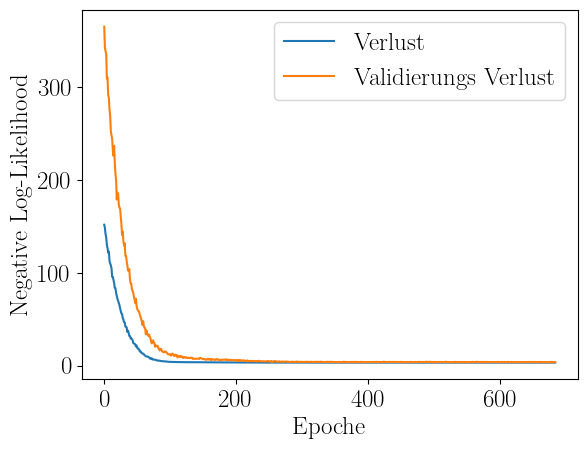

n: 1000, optimizer_iters: 15048, loss: 3.182079315185547 
theta_MLE: [[ 9.97312986]
 [19.97234204]] 
Var(theta_MLE): [[ 0.00399401 -0.00598801]
 [-0.00598801  0.01197602]] 
theta_exact: [[10.03338623]
 [19.79197791]] 
Var(theta_exact): [[ 0.00398953 -0.00597517]
 [-0.00597517  0.01193853]] 
theta_BNN: (10.689151, 17.80594) 
Var(theta_BNN): (0.04175628943363563, 0.19849012723716442)
Epoch 594: early stopping


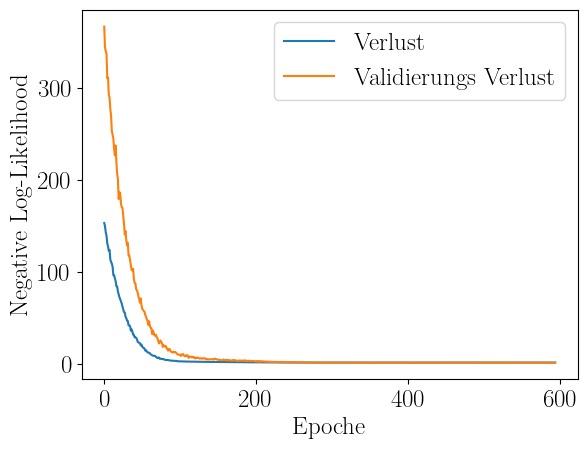

n: 1000, optimizer_iters: 13068, loss: 1.6928170919418335 
theta_MLE: [[ 9.97312986]
 [19.97234204]] 
Var(theta_MLE): [[ 0.00399401 -0.00598801]
 [-0.00598801  0.01197602]] 
theta_exact: [[10.03259015]
 [19.7937681 ]] 
Var(theta_exact): [[ 0.00398953 -0.00597517]
 [-0.00597517  0.01193853]] 
theta_BNN: (9.947113, 20.00769) 
Var(theta_BNN): (0.033919683997201355, 0.18601715726623524)


In [24]:

theta_0 = np.array([[0],[0]])
tau_0 = np.array([10])

erg5 = perform_analysis(X1000, Y1000, beta, aleatoric_noise, theta_0, tau_0)
print(erg5)

theta_0 = np.array([[10],[20]])
erg6 = perform_analysis(X1000, Y1000,beta, aleatoric_noise, theta_0, tau_0)
print(erg6)